# Golden Square Fractal (August 26, 2023 update!)

The code below draws a fractal shape with the color scheme carefully manipulated to make it pretty. See the resulting shape below the code.

__August 26 update:__ An explanation follows.

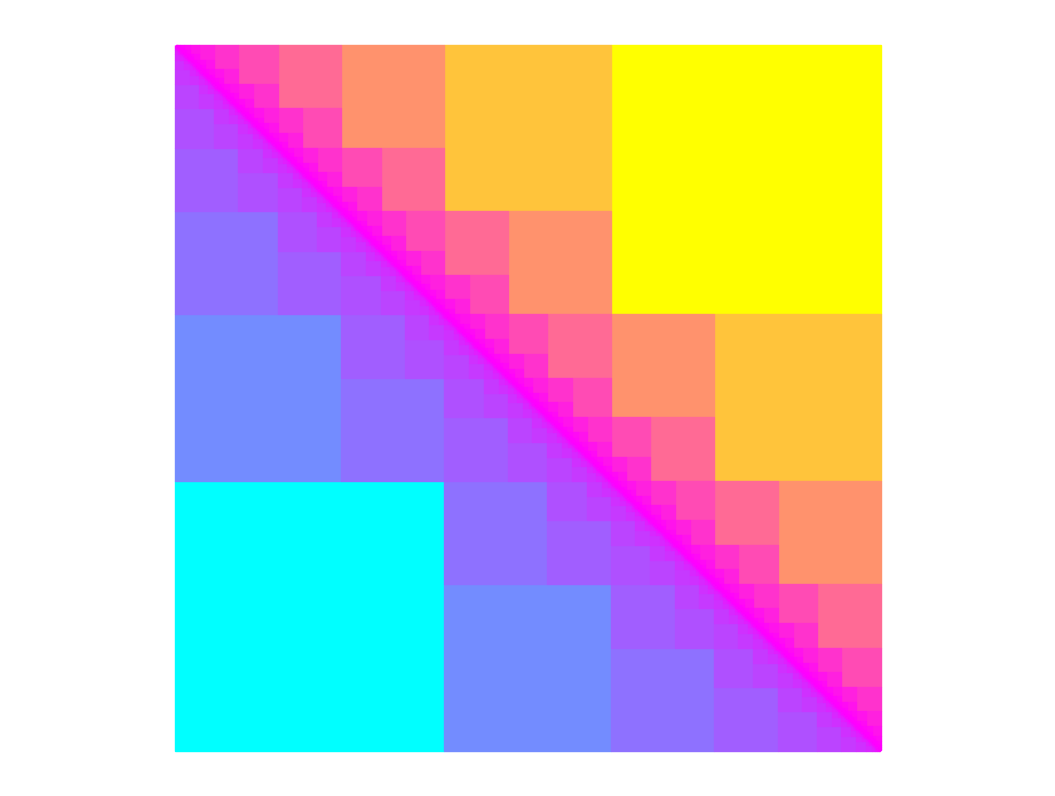

In [1]:
'''
Creates a fractal image using psi, the reciprocal of phi. i.e. phi = (1+sqrt(5))/2 and 
psi = 2/(1+sqrt(5)) = (sqrt(5)-1)/2. The code operates in iterations. The nth iteration 
produces squares with side length psi^n. The squares are arranged in such a way that 
they fill in a phi x phi square. The squares are colored in a way I thought 
looked interesting.
'''

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import chain, combinations
import numpy as np

def CreatePlot(ax, colors, colors2, depth, SECOND_HALF):
    phi = (5**.5 + 1)/2 # Golden ratio
    psi = 1/phi
    sideLength = 1
    coords = set()
    tol = 1e-5
    for i in range(0, depth): # for iteration i
        tpIncrement = sideLength # Increment to use for updating coordinates
        sideLength *= psi
        
        # Update the coords set
        if coords: # If the coords list is non-empyty, update it.
            # After the first interation, each iteration's target points come from adding 
            # a psi^(n-1) increment to the x cooridates and the y coordinates of the previous 
            # iteration's points. Thus each point of the previous iteration spawns two points.
            # But there will be some redundancy after the first few iterations. So the code
            # first adds psi^(n-1) to all the x coordinates, then uses a for loop to add the 
            # psi^(n-1) increment to the y coordinates one at a time and checks whether the
            # point is redundant before adding it to the nextCoords array.
            nextCoords = [tuple(map(lambda i, j: i+j, coord, (tpIncrement, 0))) 
                              for coord in coords] # Increment xs
            for coord in coords:
                testYCoord = tuple(map(lambda i, j: i+j, coord, 
                                       (0, tpIncrement))) # Increment y on one coord.
                good = True # Assume that the y-incremented coord is not redundant until
                            # proven otherwise.
                for testXCoord in nextCoords: # For each of the x-incremented coords,
                    if abs(testXCoord[0] - testYCoord[0]) < tol: # check it against the 
                                                                # y-incremented coord.
                        good = False # The difference is below tolerance, so the y-incremented
                                    # coord is redundant and will be disregarded.
                        break # Move on to the next y-incremented coord.
                if good:
                    nextCoords.append(testYCoord) # The y-incremented coord is not redundant,
                                                    # so save it.
            coords = nextCoords # nextCoords is complete, so it becomes this iteration's coords.           
        else: # If the coords set is empty, this is the first iteration so simply put 
              # (0,0) in the list.
            coords = [(0,0)]
        #print(len(coords))
        for coord in coords:
            square = mpatches.Rectangle(coord, sideLength, sideLength,
                                        color = colors((i/(depth))**(.3)))
            ax.add_patch(square)
            if SECOND_HALF: # The first half of the image is a right triangle with its right 
                            # angle at the lower-left. The code below reflects the triangle 
                            # towards the upper-right to form the second half of a square. 
                            # The second half is colored differently for interest.
                            
                coord2 = tuple(map(lambda i, j: i - j, (phi, phi), coord))# Elementwise 
                            # subtraction using map() + lambda. of each coordinate pair 
                            # from (phi, phi) to reflect the triangle.
                
                # The result of the subtraction is the upper-right corner location of the squares 
                # in the second half.
                square = mpatches.Rectangle(coord2, -sideLength, -sideLength, 
                                            color = colors2((1-i/(depth-1))**(10/3)))
                ax.add_patch(square)

SAVE = False
SECOND_HALF = True
depth = 14  # 14 iterations is enough. The image doesn't change in further iterations.              
# start building the plot 
phi = (5**.5 + 1)/2 # Golden ratio
ax = plt.axes([0,0,phi,phi])
colors = plt.get_cmap("cool") # Color palate for the lower-left half of the square.
colors2 = plt.get_cmap("spring") # Color palate for the upper-right half.

CreatePlot(ax, colors, colors2, depth, SECOND_HALF)
    
ax.set_xticks([]); ax.set_yticks([]) # suppress display of axes
plt.axis('equal') # adjust horizontal/vertical scales so the image renders as a square
plt.axis('off') # suppress border display

if SAVE:
    plt.savefig('square.png', bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

I'll try explaining the algorithm step by step. 

First a bit of mathematic background. As mentioned in the code comments, the fractal is built using squares whose side lengths are powers of $\psi = \frac{\sqrt 5 - 1}{2}$ which is the reciprocal of the Golden Ratio $\phi = \frac{\sqrt 5 + 1}{2}$, i.e. $\psi = \frac{1}{\phi}$. $\psi$ obeys a curious recursive property:  

```{math}
:label: psi_recursion_eqn
\psi^{n+2} + \psi^{n+1} = \psi^n
```

In words, the sum of two consecutive powers of $\psi$ equals the previous power of $\psi$. Since the component squares in the figue have side lengths of powers of $\psi$, equation {eq}`psi_recursion_eqn` will be useful in understanding the fractal.

For the remainder of this article, any text that refers to placing a square at a certain point means that the _lower left corner_ is placed at the stated point. This seems to me to be the easiest way to conceive how the algorithm works and happens to coincide with the syntax of the Matplotlib library in Python. 

Now let's break the fractal down conceptually. We'll focus on the lower-left half first. Let's see a rendering that includes axes to show the scale of the image:

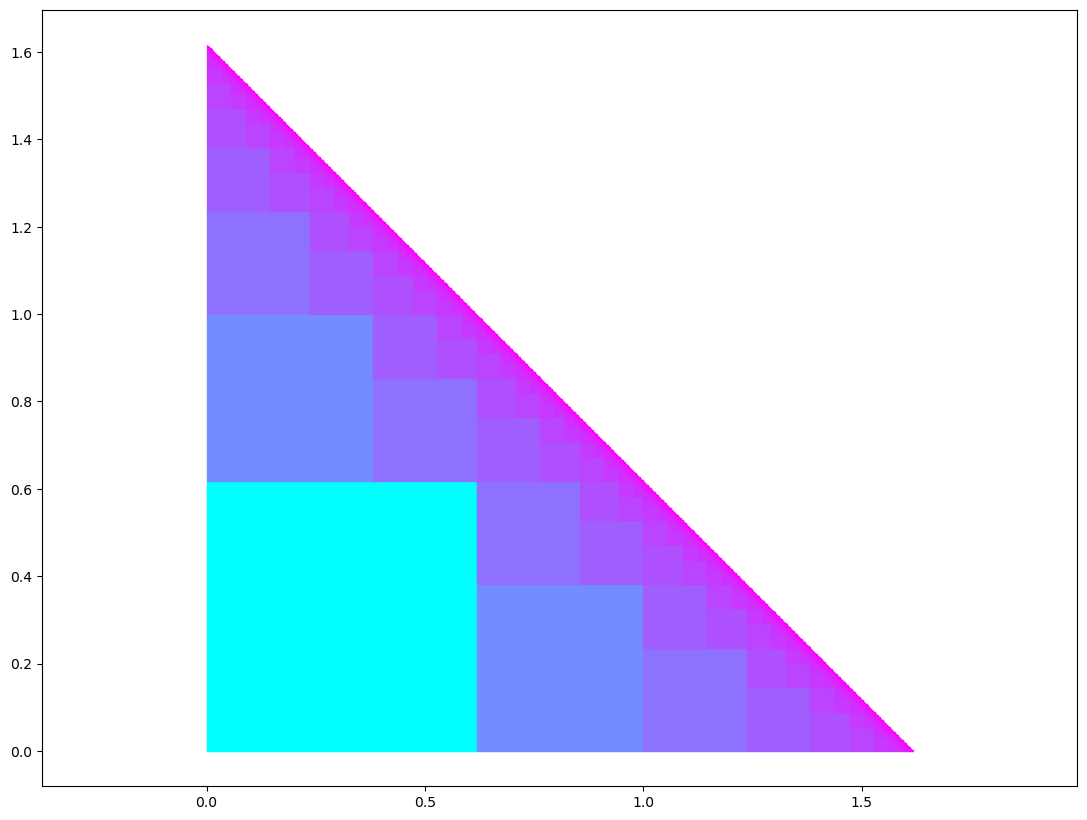

In [2]:
depth = 14                
# start building the plot
ax = plt.axes([0,0,phi,phi])

CreatePlot(ax, colors, colors2, depth, False)

plt.axis('equal') # adjust horizontal/vertical scales so the image renders as a square
plt.show()

Notice that the origin is at the lower-left corner and the fractal appears in the first quandrant, i.e. the area where $x$ and $y$ values are positive. See that the length of bottom edge length is about $1.6$. The bottom edge is formed by (in principle) infinitely many squares side-by-side each with side length $\psi^n$. The sum of the infinite series $\psi^n$ is the golden ratio $\phi \approx 1.618$. In symbols:  

$$
\sum^\infty_{n=1} \psi^n = \frac{\psi}{1-\psi} = \phi
$$

The algorithm which produces the fractal operates iteratively, and each iteration produces squares of a different size. Specifically, the $n^{th}$ iteration produces squares of side length $\psi^n$. The first iteration produces only the single largest square at the lower left. Let's see that:

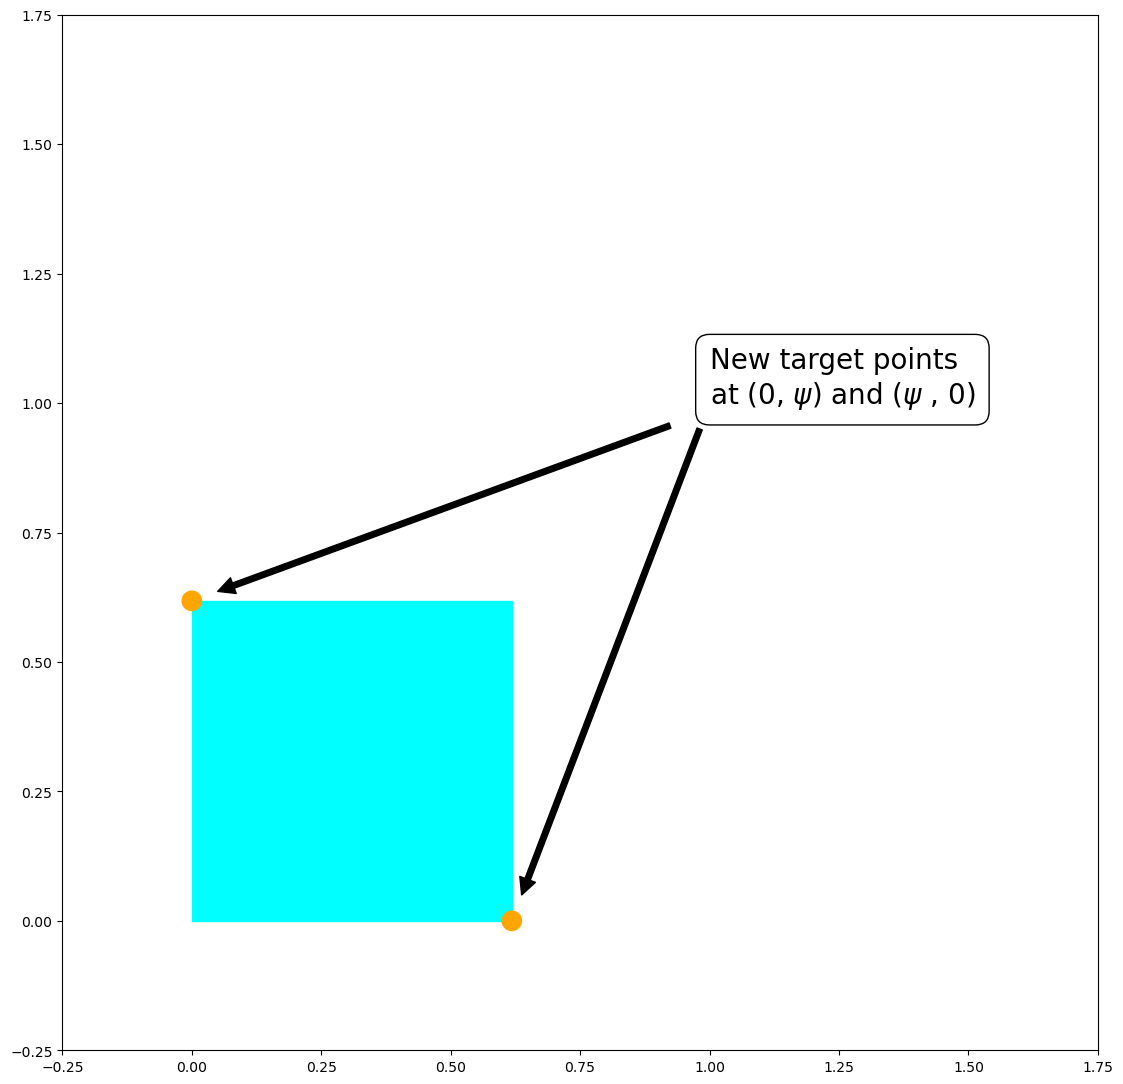

In [4]:
# start building the plot 
# Some manual axis manipulation to force the image to take a similar scale to the others.
ax = plt.axes([0,0,phi, phi * 640./480.]) 

depth = 1 # only one iteration for this figure                

CreatePlot(ax, colors, colors2, depth, False)

phi = (5**.5 + 1)/2 # Golden ratio
psi = 1/phi
ax.add_patch(mpatches.Circle((0, psi), 0.02, facecolor='orange', linewidth=3))
ax.add_patch(mpatches.Circle((psi, 0), 0.02, facecolor='orange', linewidth=3))
ax.annotate('New target points\n' + r'at (0, $\psi$) and ($\psi$ , 0)', xy=(0, 0.618), 
            xytext=(1, 1), fontsize=20,
           bbox={'boxstyle': 'Round', 'facecolor': 'white', 'alpha': 1, 'pad': .5, 'ec':'black'},
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(0.618, 0), xytext=(1, 1), fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.05))

ticks = np.linspace(-.25, 1.75, 9) # More manual axis manipulation for correct scaling.
plt.xticks(ticks); plt.yticks(ticks)
plt.show()

The first iteration simply places one $\psi \times \psi$ square at the lower left corner of the figure, i.e. at the point $(0,0)$. (Again, throughout this document, to say that a square is placed at a point means that the square is placed so that the lower left corner of the square is at the stated point). The presence of the blue square creates two new lower left points, so to speak, at $(0, \psi)$ and $(\psi, 0)$. The second iteration places squares at these two target points. See:

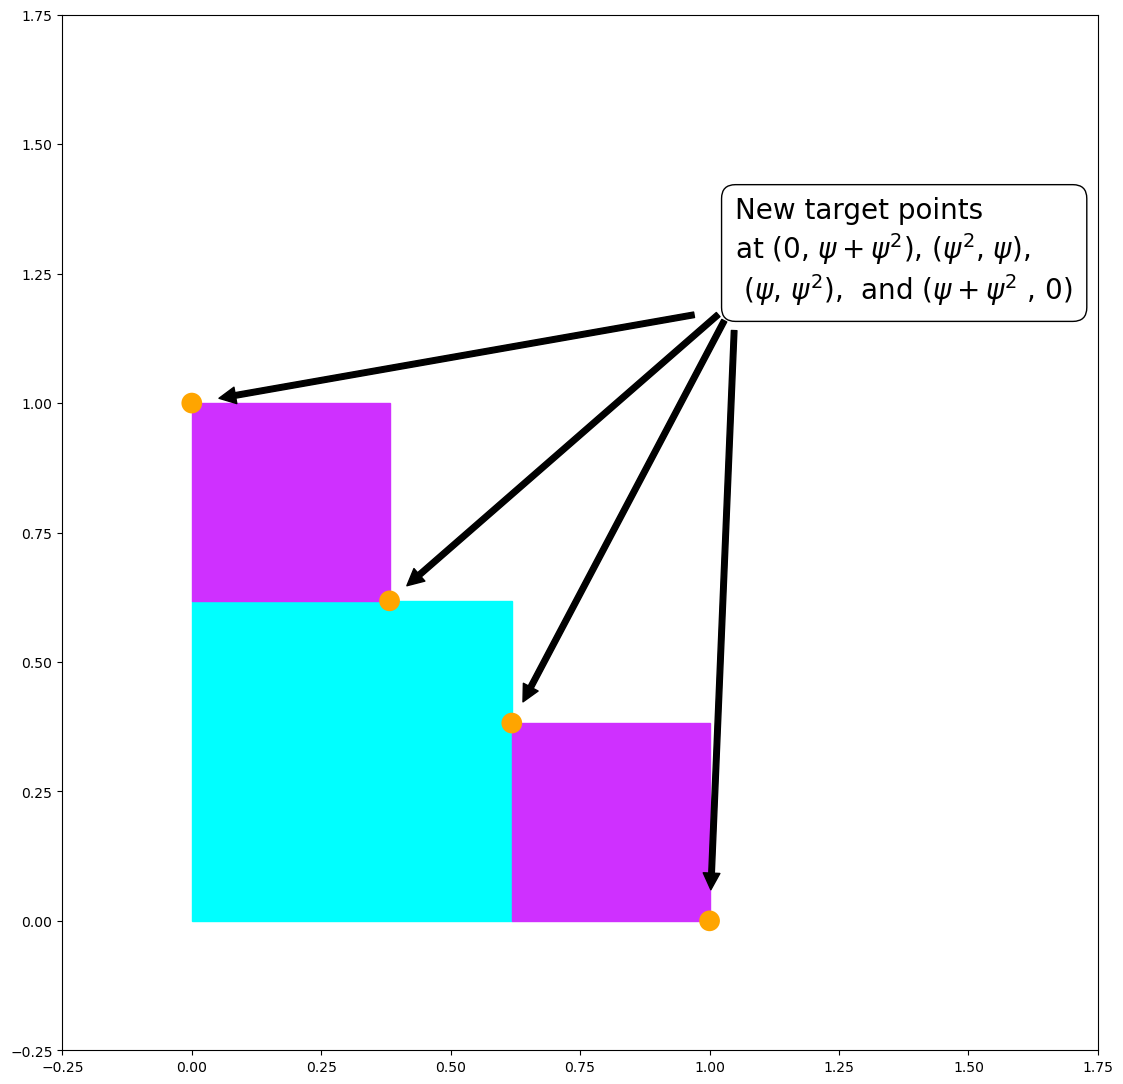

In [5]:
phi = (5**.5 + 1)/2 # Golden ratio
psi = 1/phi

# start building the plot 
# Some manual axis manipulation to force the image to take a similar scale to the others.
ax = plt.axes([0,0,phi, phi * 640./480.]) 

depth = 2 # two iterations for this figure                

CreatePlot(ax, colors, colors2, depth, False)

ax.add_patch(mpatches.Circle((0, 1), 0.02, facecolor='orange', linewidth=3))
ax.add_patch(mpatches.Circle((psi ** 2, psi), 0.02, facecolor='orange', linewidth=3))
ax.add_patch(mpatches.Circle((psi, psi ** 2), 0.02, facecolor='orange', linewidth=3))
ax.add_patch(mpatches.Circle((1, 0), 0.02, facecolor='orange', linewidth=3))



ax.annotate('New target points\n' + r'at (0, $\psi + \psi^2$), ($\psi^2$, $\psi$),' + '\n' +
            r' ($\psi$, $\psi^2$),  and ($\psi+\psi^2$ , 0)', xy=(0, 1), xytext=(1.05, 1.2),
            fontsize=20, bbox={'boxstyle': 'Round', 'facecolor': 'white', 'alpha': 1,
                               'pad': .5, 'ec':'black'},
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(psi ** 2, psi), xytext=(1.05, 1.2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(psi, psi ** 2), xytext=(1.05, 1.2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(1, 0), xytext=(1.05, 1.2), arrowprops=dict(facecolor='black', shrink=0.05))

ticks = np.linspace(-.25, 1.75, 9) # More manual axis manipulation for correct scaling.
plt.xticks(ticks); plt.yticks(ticks)
plt.show()

The placement of two new squares created the four new target points indicated in the figure: at $(0, \psi + \psi^2), (\psi^2, \psi), (\psi, \psi^2),$ and $(\psi + \psi^2, 0)$. This is our first opportunity to apply $\psi$'s recursion equation {eq}`psi_recursion_eqn`. Setting $n=0$ in {eq}`psi_recursion_eqn` yields $\psi^2 + \psi^1 = \psi^0 = 1$. The left-most and right-most target points can be written $(0,1)$ and $(1,0)$. The recursion equation {eq}`psi_recursion_eqn` will play a more important role starting in the next iteration.

Until this point, the number of squares in used for each iteration has followed a simple pattern. The first iteration used one square, the second used two squares, and we see that the third iteration will use four. It appears that the number of squares doubles with each iteration. But this pattern is about to break.

Next iteration:

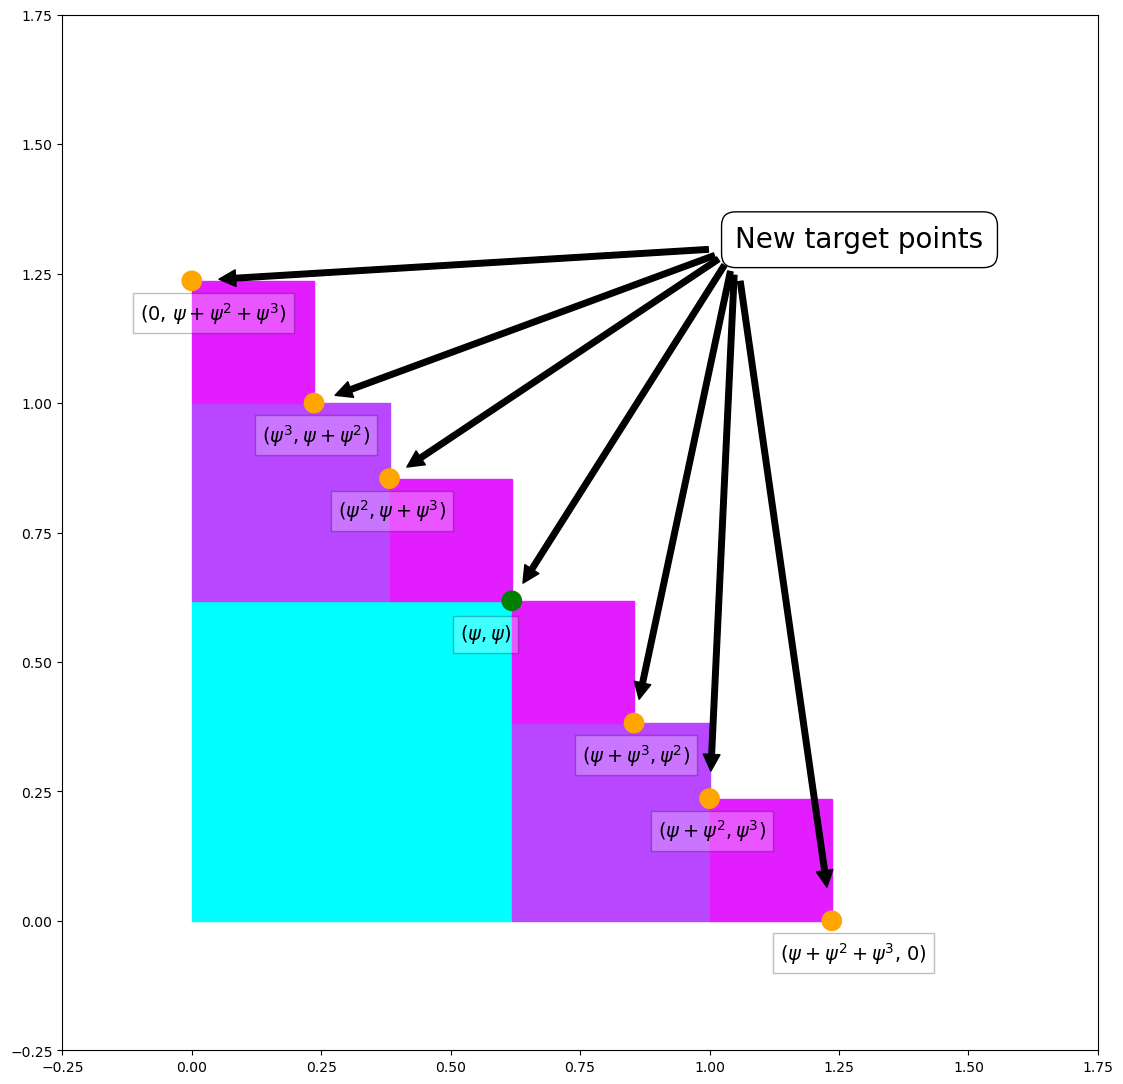

In [6]:
phi = (5**.5 + 1)/2 # Golden ratio
psi = 1/phi

# start building the plot 
# Some manual axis manipulation to force the image to take a similar scale to the others.
ax = plt.axes([0,0,phi, phi * 640./480.]) 

depth = 3 # three iterations                

CreatePlot(ax, colors, colors2, depth, False)

singleTargets = [(0, 1+psi**3), (psi**3,1), (psi**2,psi+psi**3), # Unrepeated target coordinates
                 (psi+psi**3,psi**2), (1,psi**3), (1+psi**3, 0)] 
singleTargetsText = [r'(0, $\psi+\psi^2+\psi^3$)', r'($\psi^3, \psi+\psi^2$)', # Text labels for
                     r'($\psi^2, \psi+\psi^3$)', r'($\psi+\psi^3, \psi^2$)',   # the dots on the
                     r'($\psi+\psi^2, \psi^3$)', r'($\psi+\psi^2+\psi^3$, 0)'] # unrepeated coords

tloc = (1.05, 1.3) # Annotation text location and arrow origin location
ax.annotate('New target points', xy=tloc, xytext=tloc, fontsize=20,
           bbox={'boxstyle': 'Round', 'facecolor': 'white', 'alpha': 1, 'pad': .5, 'ec':'black'})
for loc, txt in zip(singleTargets, singleTargetsText):
    ax.add_patch(mpatches.Circle(loc, 0.02, facecolor='orange', linewidth=3)) # Put an orange dot
    ax.annotate(txt, xy=loc, xytext=tuple(map(lambda i, j: i-j, # Annotate dot
                                              loc, (0.1, .075))), fontsize=14, 
                bbox={'facecolor': 'white', 'alpha': 0.25, 'pad': 5})
    ax.annotate('', xy=loc, xytext=tloc, fontsize=20, # Draw an arrow
                arrowprops=dict(facecolor='black',shrink=0.05)) 

# Special point gets a different color dot
specialTarget = (psi, psi)
ax.add_patch(mpatches.Circle((psi, psi), 0.02, facecolor='green', linewidth=3)) # Dot
ax.annotate('($\psi, \psi$)', xy=specialTarget, xytext=tuple(map(lambda i, j: i-j, 
            specialTarget, (0.1, .075))), fontsize=14, # Annotate dot
            bbox={'facecolor': 'white', 'alpha': 0.25, 'pad': 5})
ax.annotate('', xy=specialTarget, xytext=tloc, fontsize=20, # Draw an arrow
            arrowprops=dict(facecolor='black', shrink=0.05))

ticks = np.linspace(-.25, 1.75, 9) # More manual axis manipulation for correct scaling.
plt.xticks(ticks); plt.yticks(ticks)
plt.show()

This iteration only generated seven new target points instead of eight. The target point marked green in the figure is special. Notice that two magenta colored squares touch corners there. The green point is both $(\psi, \psi^2+\psi^3)$ and $(\psi^2+\psi^3, \psi)$. Recalling {eq}`psi_recursion_eqn` again, set $n=1$ and then $\psi^3+\psi^2=\psi$. So $(\psi, \psi^2+\psi^3)$ and $(\psi^2+\psi^3, \psi)$ are the same point and can both be written $(\psi, \psi)$. Since this one point took the place of two points, the total number of points was reduced by one from eight to seven.

The next iteration, the fourth one, which I won't illustrate, generates seven squares measuring $\psi^4 \times \psi^4$ and 12 new target points. The fifth iteration produces 12 $\psi^5 \times \psi^5$ squares and 20 new target points. In general, the number of squares produced in the $n^{th}$ iteration is $F_{n+2} - 1$ i.e. one less than the $n+2^{th}$ Fibonacci number. You could also say that the number of squares produced in the $n^{th}$ iteration equals the sum of the first $n$ Fibonacci numbers due to a well-known identity:  

$$
\sum_{i=1}^n F_n = F_{n+2}-1
$$

So now you have an idea how the lower left half of the fractal is produced. The code is set to run for 14 iterations because the image stops changing after 14. The upper right half is produced by reflecting the lower left half. I won't get into the gritty details of the arithmetic involved in reflection or the coloring scheme. This concludes the explanation. Hopefully somone will read this tutorial and enjoy it!